In [15]:
# https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler #
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

In [16]:
df = pd.read_excel("df_Merge_ASDnVehiclenCompany.xlsx")
df.drop(columns='Unnamed: 0', axis=1, inplace=True)
print(df.shape)
df

(299, 69)


,LKR-ID,Landkreis,KFZ,Fläche [ha],LF gesamt [ha],Anteil LF [%],Lw. Betriebe gesamt,Betriebe bis 5 ha,Betriebe 5-20 ha,Betriebe 20-50 ha,...,Betriebe Öko-LF in Umst.,LF ökologisch [ha],LW-Fläche unter 5 ha,LW-Fläche 10-20 ha,LW-Fläche 20-50 ha,LW-Fläche 50-100 ha,LW-Fläche 100-200 ha,LW-Fläche über 200 ha,Number of machinery,Sum of Number of Tractors
0,7140,LK Rhein-Hunsrück-Kreis,SIM,93414.311,37301,39.900,719,31,300,150,...,25,1913,61,3377,4979,9330,10797,8757,1,497
1,7141,LK Rhein-Lahn-Kreis,EMS,75847.110,26679,35.200,491,31,178,92,...,180,1813,69,1931,3068,7318,9321,4973,23,450
2,7143,LK Westerwaldkreis,WW,95960.505,26296,27.400,503,26,196,115,...,452,6862,80,2358,3816,6100,8649,5294,2,751
3,7231,LK Bernkastel-Wittlich,WIL,113297.133,34098,30.100,1319,645,342,129,...,226,2728,1449,3417,4083,7615,0,0,5,920
4,7232,LK Eifelkreis Bitburg-Prüm,BIT,157901.855,78482,49.700,1324,34,415,288,...,996,6309,73,5154,9951,24598,27627,11079,49,1596
5,7233,LK Vulkaneifel,DAU,88389.607,31368,35.500,585,16,237,124,...,373,3129,35,2681,4172,7180,12205,5097,21,399
6,7235,LK Trier-Saarburg,TR,107080.073,33289,31.100,1185,477,383,108,...,0,2278,1063,3694,3596,8220,0,0,13,527
7,7320,SK Zweibrücken,ZW,6860.002,2999,43.700,46,0,10,12,...,0,390,0,104,417,943,787,0,9,115
8,7331,LK Alzey-Worms,AZ,57029.172,40018,70.200,1228,293,436,257,...,216,2193,668,5193,8088,10140,12072,3856,29,1134
9,7332,LK Bad Dürkheim,DÜW,57682.370,16461,28.500,800,238,350,134,...,183,1302,529,4135,3867,3500,2508,1922,4,907


In [17]:
# Check for duplicates
idsUnique = len(set(df.Landkreis))
idsTotal = df.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

There are 0 duplicate IDs for 299 total entries


In [18]:
df.columns

Index(['LKR-ID', 'Landkreis', 'KFZ', 'Fläche [ha]', 'LF gesamt [ha]',
       'Anteil LF [%]', 'Lw. Betriebe gesamt', 'Betriebe bis 5 ha',
       'Betriebe 5-20 ha', 'Betriebe 20-50 ha', 'Betriebe 50-100 ha',
       'Betriebe 100-200 ha', 'Betriebe über 200 ha', 'Betriebe über 100 ha',
       'Anteil der Betriebe über 100 ha [%]', 'Betriebe Viehhaltung',
       'Viehbestand GV', 'Betriebe Rinder', 'Bestand Rinder', 'Milchkuhhalter',
       'Milchkühe', 'Anzahl Kälber', 'Betriebe Schweine', 'Anzahl Schweine',
       'Betriebe Zuchtsauen', 'Anzahl Zuchtsauen', 'Anzahl Ferkel',
       'Betriebe Schafe', 'Anzahl Schafe', 'Ackerbaubetriebe',
       'Betriebe Dauerkulturen', 'Betriebe Gartenbau', 'Betriebe Veredelung',
       'Betriebe Pflanzenbau', 'Betriebe Viehhaltung.1', 'Betriebe Pfl+Viehh',
       'Futterbaubetriebe', 'Ackerlandfläche [ha]', 'Grünlandfläche [ha]',
       'Fläche Dauerkulturen [ha]', 'Fläche Getreide [ha]', 'Weizen [ha]',
       'Fläche Winterweizen [ha]', 'Fläche Roggen

In [19]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = df.corr()
corr.sort_values(["Number of machinery"], ascending = False, inplace = True)
print(corr["Number of machinery"].head(20))

Find most important features relative to target
Number of machinery         1.000
Betriebe Zuchtsauen         0.607
Ackerbaubetriebe            0.601
Betriebe 50-100 ha          0.593
LW-Fläche 50-100 ha         0.589
Betriebe Schweine           0.554
Sum of Number of Tractors   0.533
Viehbestand GV              0.527
Anzahl Zuchtsauen           0.521
Lw. Betriebe gesamt         0.516
Betriebe Viehhaltung        0.514
LW-Fläche 20-50 ha          0.506
Anzahl Schweine             0.504
Betriebe 20-50 ha           0.498
Kartoffeln [ha]             0.477
Körnermais [ha]             0.468
Silomais [ha]               0.464
Fläche Triticale [ha]       0.460
Fläche Grünernte [ha]       0.454
Bestand Rinder              0.407
Name: Number of machinery, dtype: float64


In [20]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = df.select_dtypes(include = ["object"]).columns
numerical_features = df.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("Number of machinery")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
df_num = df[numerical_features]
df_cat = df[categorical_features]

Numerical features : 66
Categorical features : 2


In [21]:
# Handle remaining missing values for numerical features by using median as replacement
print("NAs for numerical features in train : " + str(df_num.isnull().values.sum()))
# df_num = df_num.fillna(train_num.median())
# print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))

NAs for numerical features in train : 0


# Dealing with outliners by means of Interquartile

In [22]:
# from scipy import stats
# sns.boxplot(x=df['Betriebe 20-50 ha'])

# # z = np.abs(stats.zscore(df.values))
# # threshold = 3
# # print(np.where(z > 3))
# # print(z[116])
# # print(z.shape)
# # df_Z = df[(z < 3).all(axis=1)]
# # print('by means of Z-score, we get df shape = {}'.format(df_Z.shape))

# # Interquartile is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers.
# Q1 = numerical_features.quantile(0.25)
# Q3 = numerical_features.quantile(0.75)
# IQR = Q3 - Q1
# print(IQR)

# df_IQR = numerical_features[~((numerical_features < (Q1 - 1.5 * IQR)) | (numerical_features > (Q3 + 1.5 * IQR))).any(axis=1)]
# print('by means of IQR, we get df shape = {}'.format(df_IQR.shape))



# log transformation

In [23]:
# Log transform of the skewed numerical features to lessen impact of outliers
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = df_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
df_num[skewed_features] = np.log1p(df_num[skewed_features])

# Log transform the target for official scoring
df["Number of machinery"] = np.log1p(df["Number of machinery"])
y = df["Number of machinery"]
df_num.columns

63 skewed numerical features to log transform


D:\anaconda\Setup\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Index(['LKR-ID', 'Fläche [ha]', 'LF gesamt [ha]', 'Anteil LF [%]',
       'Lw. Betriebe gesamt', 'Betriebe bis 5 ha', 'Betriebe 5-20 ha',
       'Betriebe 20-50 ha', 'Betriebe 50-100 ha', 'Betriebe 100-200 ha',
       'Betriebe über 200 ha', 'Betriebe über 100 ha',
       'Anteil der Betriebe über 100 ha [%]', 'Betriebe Viehhaltung',
       'Viehbestand GV', 'Betriebe Rinder', 'Bestand Rinder', 'Milchkuhhalter',
       'Milchkühe', 'Anzahl Kälber', 'Betriebe Schweine', 'Anzahl Schweine',
       'Betriebe Zuchtsauen', 'Anzahl Zuchtsauen', 'Anzahl Ferkel',
       'Betriebe Schafe', 'Anzahl Schafe', 'Ackerbaubetriebe',
       'Betriebe Dauerkulturen', 'Betriebe Gartenbau', 'Betriebe Veredelung',
       'Betriebe Pflanzenbau', 'Betriebe Viehhaltung.1', 'Betriebe Pfl+Viehh',
       'Futterbaubetriebe', 'Ackerlandfläche [ha]', 'Grünlandfläche [ha]',
       'Fläche Dauerkulturen [ha]', 'Fläche Getreide [ha]', 'Weizen [ha]',
       'Fläche Winterweizen [ha]', 'Fläche Roggen+WinterMG [ha]',
   

# Modeling

# Scale to [0;1] (give equal weight to all features, assuming a linear distribution of values and no significant outliers)
# Shift mean to 0 (to center the data set; this will not affect the output at all for most algorithms.)

In [24]:
# # Standardize numerical features
# stdSc = StandardScaler()
# X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
# X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])

In [25]:
# Join categorical and numerical features
# train = pd.concat([df_num, df_cat], axis = 1)
train = df_num
print("New number of features : " + str(train.shape[1]))

# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.25, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10)) # k-fold, set k as 10
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

New number of features : 66
X_train : (224, 66)
X_test : (75, 66)
y_train : (224,)
y_test : (75,)


# 1* Linear Regression without regularization

RMSE on Training set : 0.9871739262846895
RMSE on Test set : 5.130313868068498
Intercept: -3.736082756095743
R2 score of test:  0.2517957567099054
R2 score of train:  0.6752504128442788


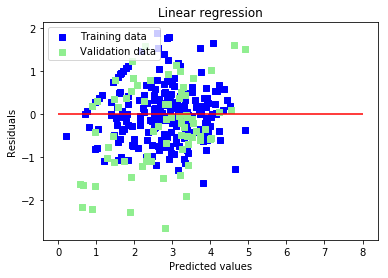

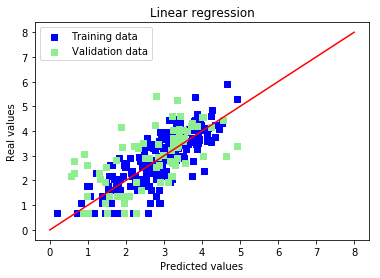

,coef,features
0,0.973,Betriebe 20-50 ha
1,0.658,Betriebe Schafe
2,0.639,Landkreis
3,0.608,LW-Fläche 100-200 ha
4,0.429,Betriebe bis 5 ha
5,0.245,Anzahl Schafe
6,0.196,Lw. Betriebe gesamt
7,0.159,Betriebe 5-20 ha
8,0.124,Betriebe Viehhaltung
9,0.102,Viehbestand GV


In [26]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# printing values
lr_coef = list(zip(lr.coef_, df.columns))
lr_coef.sort(reverse=True)
df_lr_coef = pd.DataFrame.from_records(lr_coef, columns=['coef', 'features'])

# coef_dict = {}
# for coef, feat in zip(lr.coef_[0:],df.columns):
#     coef_dict[feat] = coef
# df_lr_coef = pd.DataFrame(coef_dict)
# print(df_lr_coef)

print('Intercept:', lr.intercept_)
print('R2 score of test: ', r2_test)
print('R2 score of train: ', r2_train)

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 0, xmax = 8, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([0, 8], [0, 8], c = "red")
plt.show()

df_lr_coef.head(20)

New number of features : 66
X_train : (224, 66)
X_test : (75, 66)
y_train : (224,)
y_test : (75,)
RMSE on Training set : 0.9871739262846895
RMSE on Test set : 5.130313868068498
Intercept: -3.736082756095743
R2 score of test:  0.2517957567099054
R2 score of train:  0.6752504128442788


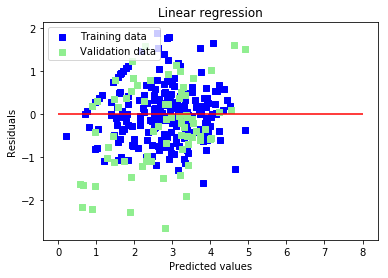

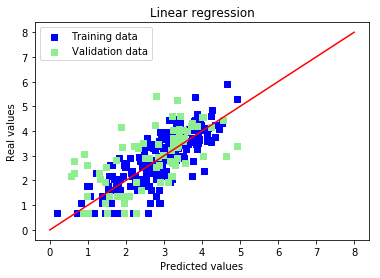

,coef,features
0,0.973,Betriebe 20-50 ha
1,0.658,Betriebe Schafe
2,0.639,Landkreis
3,0.608,LW-Fläche 100-200 ha
4,0.429,Betriebe bis 5 ha
5,0.245,Anzahl Schafe
6,0.196,Lw. Betriebe gesamt
7,0.159,Betriebe 5-20 ha
8,0.124,Betriebe Viehhaltung
9,0.102,Viehbestand GV


In [27]:
# Join categorical and numerical features
# train = pd.concat([df_num, df_cat], axis = 1)
train = df_num
print("New number of features : " + str(train.shape[1]))

# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.25, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# printing values
lr_coef = list(zip(lr.coef_, df.columns))
lr_coef.sort(reverse=True)
df_lr_coef = pd.DataFrame.from_records(lr_coef, columns=['coef', 'features'])

# coef_dict = {}
# for coef, feat in zip(lr.coef_[0:],df.columns):
#     coef_dict[feat] = coef
# df_lr_coef = pd.DataFrame(coef_dict)
# print(df_lr_coef)

print('Intercept:', lr.intercept_)
print('R2 score of test: ', r2_test)
print('R2 score of train: ', r2_train)

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 0, xmax = 8, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([0, 8], [0, 8], c = "red")
plt.show()

df_lr_coef.head(20)